The first function imports basic modules that we will be using.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
import pandas_datareader.data as web
import datetime

def _read_data(_start, _end):
    start = datetime.datetime(_start, 1, 1)
    end = datetime.datetime(_end, 1, 1)
    df = web.DataReader('MU', 'yahoo', start, end)
    return df

Read data and set it to a variable.

In [3]:
df = _read_data(2012, 2017)

Append all features to the dataframe.
Stochostic %K

In [4]:
def _stochk(df, n):
    formula = (((df.Close - df.Low.rolling(n).min())) / (df.High.rolling(n).max() - df.Low.rolling(n).min())) * 100
    stochk = pd.Series(formula, name = '%K')
    df = df.join(stochk)
    return df

Stochostic %D

In [5]:
def _stochd(df):
    formula = df['%K'].rolling(3).mean()
    stochd = pd.Series(formula, name = '%D')
    df = df.join(stochd)
    return df

On-Balance Volume

In [6]:
def _obv(df): 
    previousClose = 0
    values = []
    values.append(previousClose)
    for index, row in df[1:].iterrows():
        if(row['Close'] > previousClose):
            values.append(row['Volume'])
            previousClose = row['Close']
        else:
            values.append(-row['Volume'])
            previousClose = row['Close']
    df['OBV'] = np.cumsum(np.array(values)) # On-balance Volume formula.
    return df

Moving Average

In [7]:
def _ma(df, n): # df for dataframe, n for time.
    formula = df['Close'].rolling(n).mean() 
    ma = pd.Series(formula, name = 'MA'+str(n))
    df = df.join(ma)
    return df

Oscillator Close Price

In [8]:
def _oscp(df): # formula for price oscillator: MA5 − MA10/MA5.
    formula = (df['Close'].rolling(5).mean() - (df['Close'].rolling(10).mean() / df['Close'].rolling(5).mean()))
    oscp = pd.Series(formula, name = 'Oscp')
    df = df.join(oscp)
    return df

Calculates the total mean absolute error.

In [9]:
def _mae(df):
    mae = []
    for index, row in df.iterrows():
        mae.append(abs((row['Predict'] - row['Actual'])))
    df['Mae'] = mae
    
    total = df['Mae'].sum()
    total_mae = total / len(df['Mae'])
    
    return total_mae

In [10]:
df = _stochk(df, 14)
df = _stochd(df)
df = _ma(df, 5)
df = _obv(df)
df = _oscp(df)

Then we remove features that we think are irrelevant.

In [11]:
df = df.drop(['High', 'Low', 'Adj Close'], axis=1)

Our dataframe looks like this now.

In [12]:
print(df)

                 Open      Close    Volume         %K         %D        MA5  \
Date                                                                          
2012-01-03   6.640000   6.760000  42035300        NaN        NaN        NaN   
2012-01-04   6.700000   6.990000  43038500        NaN        NaN        NaN   
2012-01-05   6.960000   7.160000  53469800        NaN        NaN        NaN   
2012-01-06   7.170000   7.200000  33006500        NaN        NaN        NaN   
2012-01-09   7.230000   7.290000  28692200        NaN        NaN   7.080000   
2012-01-10   7.400000   7.250000  26672800        NaN        NaN   7.178000   
2012-01-11   7.270000   7.220000  20210400        NaN        NaN   7.224000   
2012-01-12   7.220000   7.270000  30026700        NaN        NaN   7.246000   
2012-01-13   7.220000   7.230000  29225000        NaN        NaN   7.252000   
2012-01-17   7.300000   7.160000  30684100        NaN        NaN   7.226000   
2012-01-18   7.250000   7.650000  48911100        Na

Next, we need to look for every possible combination of dataframe columns.

In [13]:
from itertools import combinations
import itertools as iter

def _get_combinations(df):
    # Find combination for every l within in range of length of column + 1.
    cc = list(combinations(df.columns, l) for l in range(len(df.columns) + 1))
    # Set the combinations to a variable called possible_cc.
    possible_cc = list(iter.chain.from_iterable(cc))
    
    ix = []
    mae_list = []
    
    for c in possible_cc:
        combo = list(c)
        if any('Close' in f for f in combo):
            mae_list.append(_linear_predict(df[combo]))
            ix.append(list(c))
            
    mae_series = pd.Series(mae_list, name = 'Total MAE')
    ix_series = pd.Series(ix, name = 'Features')
    
    evaluation_df = pd.DataFrame(ix_series)
    evaluation_df = evaluation_df.join(mae_series)
    evaluation_df.set_index('Features', inplace=True)
    
    return evaluation_df.nsmallest(5, 'Total MAE')

From this function, we will b able to get our X_train, y_train, X_test and y_test.

In [14]:
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

def _load_data(df, n):
    df['Label'] = df['Close'].shift(n)
    df = df.dropna()   
    
    X = np.array(df.drop(['Label'], 1)) 
    y = np.array(df['Label'])
    
    y = y.reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(y)
    X = scaler.transform(X)
    y = scaler.transform(y)
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return (X_train, y_train), (X_test, y_test)

Build a model with LSTM.

In [15]:
import keras
import tensorflow as tf
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM


def _build_lstm(neurons, hidden_neurons):
    model = Sequential()
    model.add(LSTM(hidden_neurons, return_sequences=False, input_shape=(None, neurons)))
    model.add(Dense(neurons, input_dim=hidden_neurons))  
    model.add(Activation("linear"))  
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    model.summary()
    return model

Using TensorFlow backend.


Building our linear regression here.

In [16]:
from sklearn.linear_model import LinearRegression

def _linear_predict(df):
    (X_train, y_train), (X_test, y_test) = _load_data(df, -1)
    
    linear = LinearRegression()
    linear.fit(X_train, y_train.reshape(len(y_train),))
    prediction = linear.predict(X_test)
    
    a = prediction - y_test[:,0]
    mae_value = sum(abs(a)) / len(a)
    
    return mae_value

Loop through the top 5 features and take the value for each row and append a new column to the dataframe.

In [17]:
def _pdlstm_data(df, evaluation):
    evaluation = evaluation.reset_index()
    
    mae1 = list()
    mae2 = list()
    mae3 = list()
    mae4 = list()
    mae5 = list()
    
    for index, row in evaluation.iterrows():
        mlist = _train_lstm(df[row['Features']], 300)
        mae1.append(mlist[0])
        mae2.append(mlist[1])
        mae3.append(mlist[2])
        mae4.append(mlist[3])
        mae5.append(mlist[4])
    
    evaluation['MAE 1LSTM'] = mae1
    evaluation['MAE 2LSTM'] = mae2
    evaluation['MAE 3LSTM'] = mae3
    evaluation['MAE 4LSTM'] = mae4
    evaluation['MAE 5LSTM'] = mae5
    return evaluation

In [18]:
def _train_lstm(df, hidden_neurons):
    
    model = _build_lstm(1, hidden_neurons)
    # for i in every range of 1, go back one step, at the end of the table append predicted value to a array.
    
    graph = pd.DataFrame(index=np.arange(207))
    mlist = list()
    
    for n in range(1 , 6):
        (X_train, y_train), (X_test, y_test) = _load_data(df, -n)
    
    
        X_train = X_train.reshape(-1, X_train.shape[1], 1)
        X_test = X_test.reshape(-1, X_test.shape[1], 1)
    
        model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)
        model.compile(loss="mean_squared_error", optimizer="adam")
 
        predicted = model.predict(X_test)
        
        p = pd.Series(np.array(predicted[:,0]), name = "Predicted "+str(n))
        e = pd.Series(np.array(y_test[:,0]), name = "Expected "+str(n))
        
        graph = graph.join(p)
        graph = graph.join(e)
        
        a = predicted[:,0] - y_test[:,0]
        mae_value = sum(abs(a)) / len(a)
        
        mlist.append(mae_value)
    
    graph.plot(linewidth=0.5)
    
    return mlist

Find all possible combinations that has 'Close' feature in it then calculate the total mean absolute error to choose our top 5 best results that we will be using for LSTM.

In [19]:
evaluation = _get_combinations(df)
print(evaluation)

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


                         Total MAE
Features                          
[Close, %K, %D]           0.033052
[Close, %K, %D, OBV]      0.033087
[Close, %K, %D, MA5]      0.033089
[Close, Volume, %K, %D]   0.033093
[Close, %K, %D, Oscp]     0.033099


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Train on 983 samples, validate on 52 samples
Epoch 1/10
983/983 [==============================] - 0s - loss: 1.1887 - val_loss: 0.4249
Epoch 2/10
983/983 [==============================] - 0s - loss: 1.0651 - val_loss: 0.5517
Epoch 3/10
983/983 [==============================] - 0s - loss: 0.8808 - val_loss: 0.4051
Epoch 4/10
983/983 [==============================] - 0s - loss: 0.7103 - val_loss: 0.3856
Epoch 5/10
983/983 [==============================] - 0s - loss: 0.5030 - val_loss: 0.1591
Epoch 6/10
983/983 [==============================] - 0s - loss: 0.3171 - val_loss: 0.2627
Epoch 7/10
983/983 [==============================] - 0s - loss: 0.2575 - val_loss: 0.0383
Epoch 8/10
983/983 [==============================] - 0s - loss: 0.1399 - val_loss: 0.0818
Epoch 9/10
983/983 [==============================] - 0s - loss: 0.0904 - val_loss: 0.0326
Epoch 10/10
983/983 [==============================] - 0s - loss: 0.1155 - val_loss: 0.1491
Train on 983 samples, validate on 52 samples

<IPython.core.display.Javascript object>


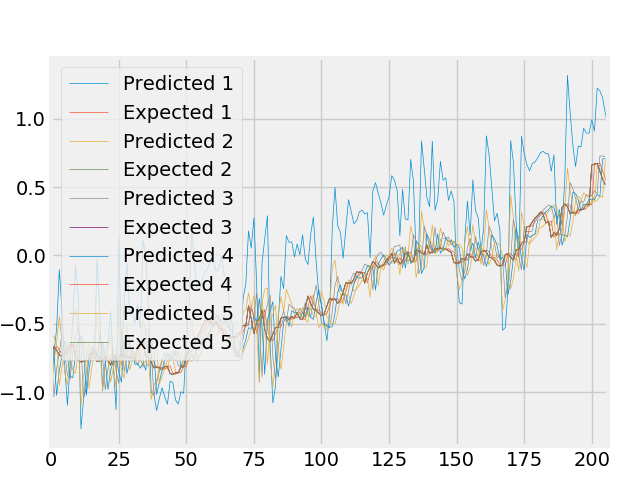

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Train on 983 samples, validate on 52 samples
Epoch 1/10
983/983 [==============================] - 0s - loss: 1.0059 - val_loss: 0.9830
Epoch 2/10
983/983 [==============================] - 0s - loss: 0.6210 - val_loss: 0.8237
Epoch 3/10
983/983 [==============================] - 0s - loss: 0.5714 - val_loss: 0.5059
Epoch 4/10
983/983 [==============================] - 0s - loss: 0.5372 - val_loss: 0.6189
Epoch 5/10
983/983 [==============================] - 0s - loss: 0.4214 - val_loss: 0.9031
Epoch 6/10
983/983 [==============================] - 0s - loss: 0.3685 - val_loss: 0.4610
Epoch 7/10
983/983 [==============================] - 0s - loss: 0.2550 - val_loss: 0.3595
Epoch 8/10
983/983 [==============================] - 0s - loss: 0.1802 - val_loss: 0.6648
Epoch 9/10
983/983 [==============================] - 0s - loss: 0.2521 - val_loss: 0.1132
Epoch 10/10
983/983 [==============================] - 0s - loss: 0.0796 - val_loss: 0.0647
Train on 983 samples, validate on 52 samples

<IPython.core.display.Javascript object>


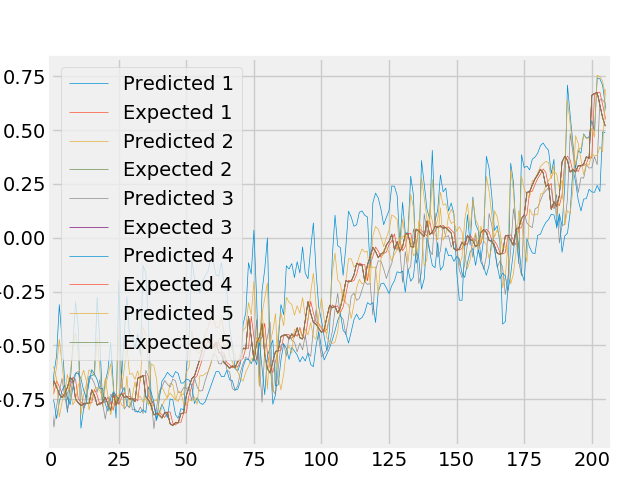

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
Train on 983 samples, validate on 52 samples
Epoch 1/10
983/983 [==============================] - 0s - loss: 1.2926 - val_loss: 0.5618
Epoch 2/10
983/983 [==============================] - 0s - loss: 1.1011 - val_loss: 0.6719
Epoch 3/10
983/983 [==============================] - 0s - loss: 1.0199 - val_loss: 0.6965
Epoch 4/10
983/983 [==============================] - 0s - loss: 0.9663 - val_loss

<IPython.core.display.Javascript object>


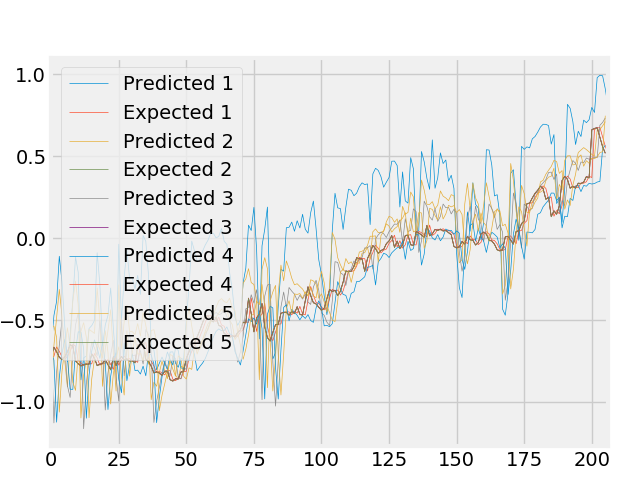

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
Train on 983 samples, validate on 52 samples
Epoch 1/10
983/983 [==============================] - 2s - loss: 2.2977 - val_loss: 0.3771
Epoch 2/10
983/983 [==============================] - 0s - loss: 1.1475 - val_loss: 0.3121
Epoch 3/10
983/983 [==============================] - 0s - loss: 1.1157 - val_loss: 0.3036
Epoch 4/10
983/983 [==============================] - 0s - loss: 1.0814 - val_loss

<IPython.core.display.Javascript object>


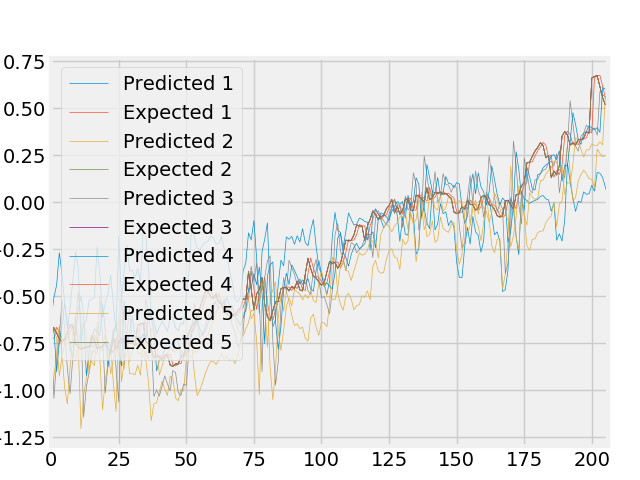

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
Train on 983 samples, validate on 52 samples
Epoch 1/10
983/983 [==============================] - 0s - loss: 1.2428 - val_loss: 0.5738
Epoch 2/10
983/983 [==============================] - 0s - loss: 1.0585 - val_loss: 0.4815
Epoch 3/10
983/983 [==============================] - 0s - loss: 1.0142 - val_loss: 0.7096
Epoch 4/10
983/983 [==============================] - 0s - loss: 0.9294 - val_loss

<IPython.core.display.Javascript object>


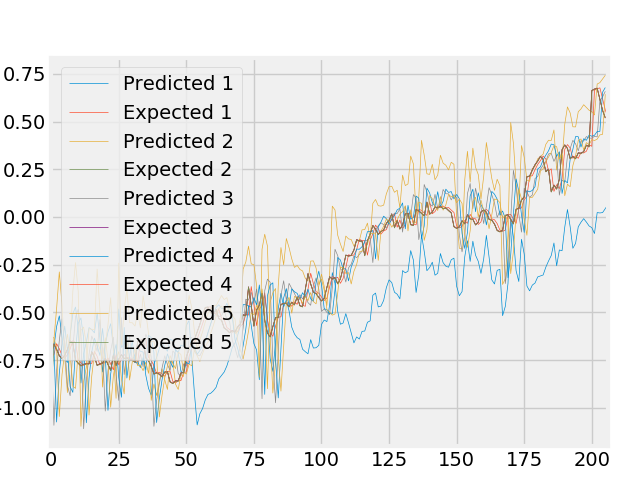

In [20]:
evaluation = _pdlstm_data(df, evaluation)

In [21]:
print(evaluation)

                  Features  Total MAE  MAE 1LSTM  MAE 2LSTM  MAE 3LSTM  \
0          [Close, %K, %D]   0.033052   0.386476   0.115542   0.103969   
1     [Close, %K, %D, OBV]   0.033087   0.189007   0.106917   0.099204   
2     [Close, %K, %D, MA5]   0.033089   0.342352   0.156967   0.121216   
3  [Close, Volume, %K, %D]   0.033093   0.214389   0.224414   0.120508   
4    [Close, %K, %D, Oscp]   0.033099   0.251890   0.170811   0.102448   

   MAE 4LSTM  MAE 5LSTM  
0   0.100084   0.092778  
1   0.136794   0.089441  
2   0.106376   0.121709  
3   0.093316   0.102964  
4   0.103096   0.098863  
